# Classificação de Estágios da Doença de Alzheimer

## Support Vector Machine

SVM (Support Vector Machine) é um algoritmo de aprendizado de máquina utilizado para classificação e regressão, que busca encontrar o hiperplano que melhor separa diferentes classes de dados, maximizando a margem entre elas. Ele pode lidar com dados lineares e não lineares usando a técnica de kernels.

### Bibliotecas

In [22]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.calibration import label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    hamming_loss,
    jaccard_score,
    log_loss,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

### Variáveis iniciais

In [23]:
# Valor fixo de seed para reprodutibilidade
random_seed = 42

# Pasta do dataset
dataset_folder = "../data/Alzheimer_MRI_4_classes_dataset"
folders = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

# Número máximo de imagens a serem carregadas em cada classe
max_images_per_class = 100

### Random Seed

In [24]:
random.seed(random_seed)
np.random.seed(random_seed)

### Carregar dados

In [25]:
# Função para carregar e pré-processar as imagens
# def load_images(dataset_folder, folders, image_size=(128, 128), max_images_per_class=100):
#     images = []
#     labels = []
#     for folder in folders:
#         folder_path = os.path.join(dataset_folder, folder)
#         if os.path.exists(folder_path):
#             count = 0
#             for img_name in os.listdir(folder_path):
#                 if count >= max_images_per_class:
#                     break
#                 img_path = os.path.join(folder_path, img_name)
#                 image = Image.open(img_path).convert("RGB")
#                 image = image.resize(image_size)
#                 images.append(np.array(image).flatten())  # Flatten the image
#                 labels.append(folder)
#                 count += 1
#     return np.array(images), np.array(labels)

# Função para carregar e pré-processar as imagens
def load_images(dataset_folder, folders, image_size=(176, 128), max_images_per_class=100):
    images = []
    labels = []
    for folder in folders:
        folder_path = os.path.join(dataset_folder, folder)
        if os.path.exists(folder_path):
            count = 0
            for img_name in os.listdir(folder_path):
                if count >= max_images_per_class:
                    break
                img_path = os.path.join(folder_path, img_name)
                try:
                    image = Image.open(img_path).convert("RGB")
                    image = image.resize(image_size)  # Redimensionar para 176x128
                    image = np.array(image).flatten()  # Flatten a imagem para 1D
                    images.append(image)
                    labels.append(folder)
                    count += 1
                except Exception as e:
                    print(f"Erro ao processar a imagem {img_name}: {e}")
    return np.array(images), np.array(labels)

### Rótulos

In [26]:
# Carregar as imagens e os rótulos
X, y = load_images(dataset_folder, folders, max_images_per_class=max_images_per_class)

# Codificar os rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalizar as imagens
X = X / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]

### Dividir em treino e teste

In [27]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=random_seed)

In [28]:
# Tamanho do conjunto de treinamento
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Tamanho do conjunto de teste
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (291, 67584)
y_train shape: (291,)
X_test shape: (73, 67584)
y_test shape: (73,)


### Treinar o modelo

In [29]:
# Treinar um classificador SVM
clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

### Predizer utilizando o modelo treinado

In [30]:
# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

### Métricas

In [31]:
# Acurácia

print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.6712328767123288


In [32]:
# Relatório de classificação

print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Relatório de classificação:
                  precision    recall  f1-score   support

    MildDemented       0.74      0.77      0.75        26
ModerateDemented       1.00      1.00      1.00         9
     NonDemented       0.67      0.63      0.65        19
VeryMildDemented       0.42      0.42      0.42        19

        accuracy                           0.67        73
       macro avg       0.71      0.71      0.71        73
    weighted avg       0.67      0.67      0.67        73



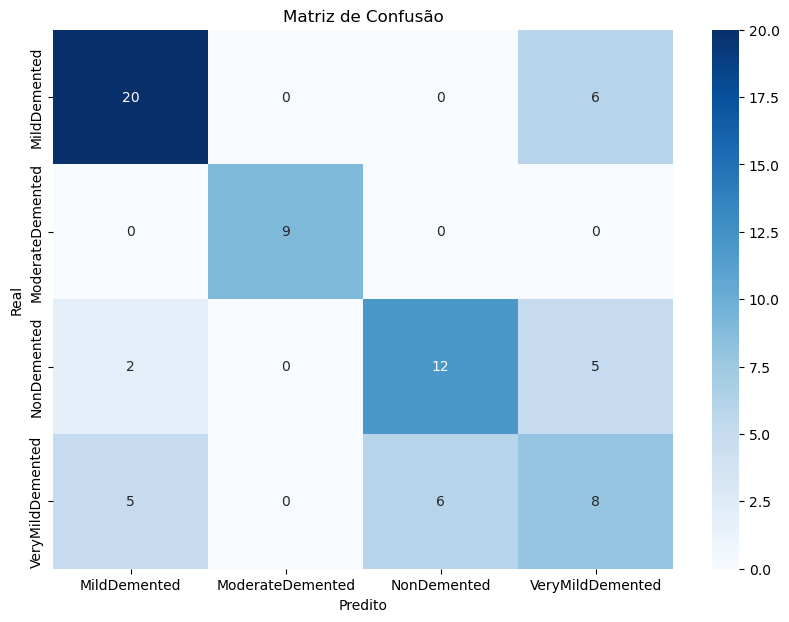

In [33]:
# Matriz de confusão
# É uma ferramenta visual que mostra o desempenho do modelo em cada classe

cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão usando Seaborn com a paleta Set2
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [34]:
# Área sobre a curva ou AUC para cada classe

y_test_binarized = label_binarize(y_test, classes=np.arange(len(folders)))
auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

AUC: 0.8968337145828746


In [35]:
# Log Loss (Logarithmic Loss)
# Mede a incerteza das previsões. Penaliza previsões incorretas com alta confiança mais severamente do que previsões incorretas com baixa confiança.

log_loss_value = log_loss(y_test, y_pred_proba)
print("Log Loss:", log_loss_value)

Log Loss: 0.6704110184156531


In [36]:
# Cohen's Kappa
# Mede a concordância entre as previsões do modelo e os rótulos verdadeiros, ajustando para a concordância que ocorre por acaso.

kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.5441061670569868


In [37]:
# Hamming Loss
# Mede a fração de rótulos incorretamente previstos. É útil para problemas multilabel.

hamming = hamming_loss(y_test, y_pred)
print("Hamming Loss:", hamming)

Hamming Loss: 0.3287671232876712


In [38]:
# Jaccard Index
# Mede a similaridade entre os conjuntos de rótulos previstos e os rótulos verdadeiros.

jaccard = jaccard_score(y_test, y_pred, average='macro')
print("Jaccard Index:", jaccard)

Jaccard Index: 0.5881818181818181


In [39]:
# Matthews Correlation Coefficient (MCC)
# Considera todos os elementos da matriz de confusão e é uma métrica equilibrada que pode ser usada mesmo se as classes tiverem tamanhos muito diferentes.

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.5442489674784002
